In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.interpolate import griddata
import copy


---
# VIDEO: Upsampling
---


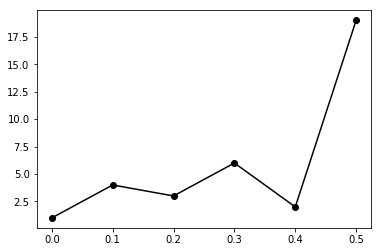

In [24]:
## low-sampling-rate data to upsample

# in Hz
srate = 10

# just some numbers...
data  = np.array( [1, 4, 3, 6, 2, 19] )

# other parameters
npnts = len(data)
time  = np.arange(0,npnts)/srate

# plot the original signal
plt.plot(time,data,'ko-')
plt.show()

In [25]:
## option 1: upsample by a factor

upsampleFactor = 4
newNpnts = npnts*upsampleFactor

# new time vector after upsampling
newTime = np.arange(0,newNpnts)/(upsampleFactor*srate)

In [26]:
## option 2: upsample to desired frequency, then cut off points if necessary

# in Hz
newSrate = 37
 
# need to round in case it's not exact
newNpnts = np.round( npnts * (newSrate/srate) )
 
# new time vector after upsampling
newTime = np.arange(0,newNpnts) / newSrate


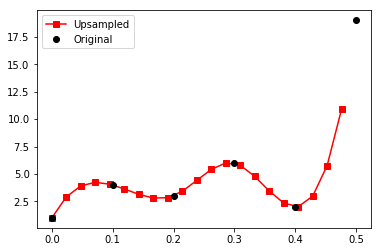

In [41]:
## continue on to interpolation

# cut out extra time points
newTime = newTime[newTime<time[-1]]

# the new sampling rate actually implemented
newSrateActual = 1/np.mean(np.diff(newTime))



# interpolate using griddata
updataI = griddata(time, data, newTime, method='cubic')

# plot the upsampled signal
plt.plot(newTime,updataI,'rs-',label='Upsampled')
plt.plot(time,data,'ko',label='Original')
plt.legend()
plt.show()

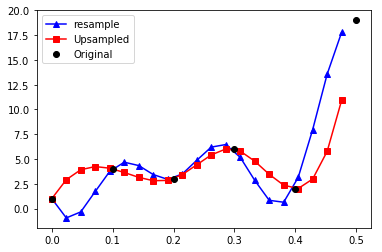

In [45]:
## using Python's resample function

# new sampling rate in Hz
newSrate = 42


# use resample function
newNpnts = int( len(data)*newSrate/srate )
updataR = signal.resample(data,newNpnts)

# the new time vector
newTimeR = np.arange(0,newNpnts)/newSrate


# cut out extra time points
updataR  = updataR[newTimeR<time[-1]]
newTimeR = newTimeR[newTimeR<time[-1]]


# and plot it
plt.plot(newTimeR,updataR,'b^-',label='resample')
plt.plot(newTime,updataI,'rs-',label='Upsampled')
plt.plot(time,data,'ko',label='Original')
plt.legend()
plt.show()


---
# VIDEO: Downsampling
---


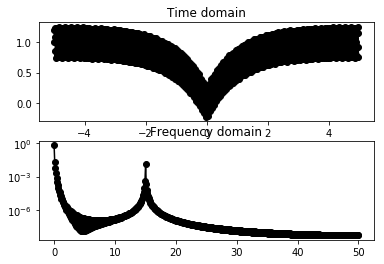

In [20]:
## Laplace distribution

# parameters
srate  = 100
tv     = np.arange(-5,5-1/srate,1/srate)
npnts  = len(tv)

# signal components
laplace  = 1-np.exp(-np.abs(tv))
fastsine = .25*np.sin(2*np.pi*tv*15)

# combine into one signal (no noise)
signal1 = laplace + fastsine

# power spectrum (O = original)
hzO = np.linspace(0,srate/2,int(np.floor(npnts/2)+1))
signalO_pow = np.abs(scipy.fftpack.fft(signal1)/npnts)**2
signalO_pow = signalO_pow[:len(hzO)]


# time domain signal
plt.subplot(211)
plt.plot(tv,signal1,'ko-')
plt.title('Time domain')
## optional manual zoom:
#plt.xlim([0,1])


# show power spectrum
plt.subplot(212)
plt.plot(hzO,signalO_pow,'ko-')
plt.yscale('log')
plt.title('Frequency domain')
plt.show()


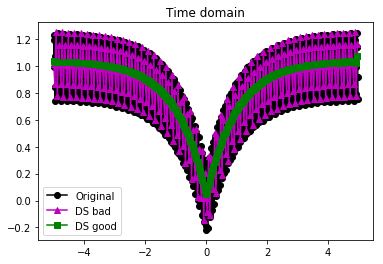

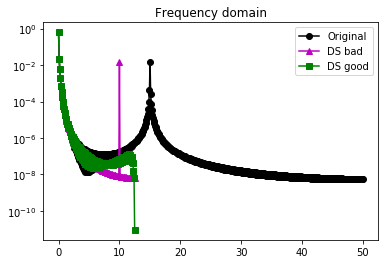

In [21]:
## downsample by a factor

dnsampleFactor = 4
newSrate = srate/dnsampleFactor

# new time vector after upsampling
newTv = np.arange(-5,5,1/newSrate)
newPnts = len(newTv)



### downsample WITHOUT low-pass filtering (bad idea!!)
signal_dsB = signal1[:-1:dnsampleFactor]

# power spectrum (B = bad)
hz_ds = np.linspace(0,newSrate/2,int(np.floor(newPnts/2)+1))
signal_dsB_pow = np.abs(scipy.fftpack.fft(signal_dsB)/newPnts)**2
signal_dsB_pow = signal_dsB_pow[:len(hz_ds)]


### low-pass filter at new Nyquist frequency! (good idea!!)
fkern = signal.firwin(int(14*newSrate/2),newSrate/2,fs=srate,pass_zero=True)
fsignal = signal.filtfilt(fkern,1,signal1)

# now downsample
signal_dsG = fsignal[:-1:dnsampleFactor]

# power spectrum (G = good)
signal_dsG_pow = np.abs(scipy.fftpack.fft(signal_dsG)/newPnts)**2
signal_dsG_pow = signal_dsG_pow[:len(hz_ds)]

fsignal_pow = np.abs(scipy.fftpack.fft(fsignal)/npnts)**2
fsignal_pow = fsignal_pow[:len(hz_ds)]



# plot in the time domain
plt.plot(tv,signal1,'ko-',label='Original')
plt.plot(newTv,.02+signal_dsB,'m^-',label='DS bad')
plt.plot(newTv,.04+signal_dsG,'gs-',label='DS good')
plt.legend()
## optional change in xlimit to zoom in
#plt.xlim([1,2])
plt.title('Time domain')
plt.show()

# plot in the frequency domain
plt.plot(hzO,signalO_pow,'ko-',label='Original')
plt.plot(hz_ds,signal_dsB_pow,'m^-',label='DS bad')
plt.plot(hz_ds,signal_dsG_pow,'gs-',label='DS good')
plt.legend()
plt.title('Frequency domain')
plt.yscale('log')
plt.show()


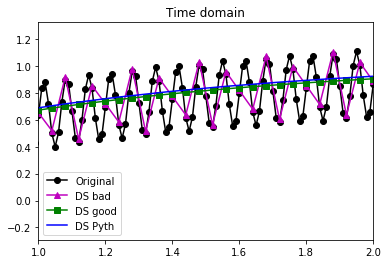

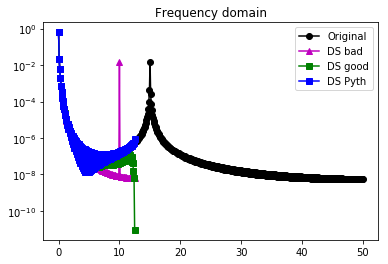

In [23]:
## using Python's resample function

# use resample function
signal_dsP = signal.resample(signal1,newPnts)


# power spectrum (P=Python)
signal_dsP_pow = np.abs(scipy.fftpack.fft(signal_dsP)/newPnts)**2
signal_dsP_pow = signal_dsP_pow[:len(hz_ds)]


# plot in the time domain
plt.plot(tv,signal1,'ko-',label='Original')
plt.plot(newTv,.02+signal_dsB,'m^-',label='DS bad')
plt.plot(newTv,.04+signal_dsG,'gs-',label='DS good')
plt.plot(newTv,.06+signal_dsP,'b-',label='DS Pyth')
plt.legend()
## optional change in xlimit to zoom in
plt.xlim([1,2])
plt.title('Time domain')
plt.show()



# frequency domain
plt.plot(hzO,signalO_pow,'ko-',label='Original')
plt.plot(hz_ds,signal_dsB_pow,'m^-',label='DS bad')
plt.plot(hz_ds,signal_dsG_pow,'gs-',label='DS good')
plt.plot(hz_ds,signal_dsP_pow,'bs-',label='DS Pyth')
plt.legend()
plt.title('Frequency domain')
plt.yscale('log')
plt.show()




---
# VIDEO: Strategies for multirate signals
---


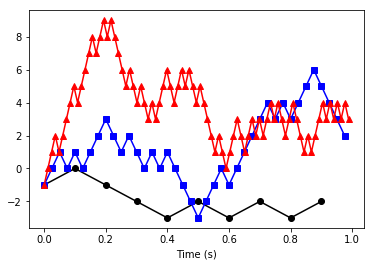

In [35]:
## create multichannel signal with multiple sampling rates

# initialize signals, time vectors, and sampling rates

# sampling rates in Hz
fs = [10,40,83]
timez = np.zeros([3],dtype=object)
signals = np.zeros([3],dtype=object)



# create signals
for si in range(0,3):
    
    # create signal
    signals[si] = np.cumsum( np.sign(np.random.randn(fs[si])) )
    
    # create time vector
    timez[si] = np.arange(0,fs[si])/fs[si]



# # plot all signals
color = 'kbr'
shape = 'os^'

for si in range(0,3):
    plt.plot(timez[si],signals[si],color[si]+shape[si]+'-')

plt.xlabel('Time (s)')
plt.show()

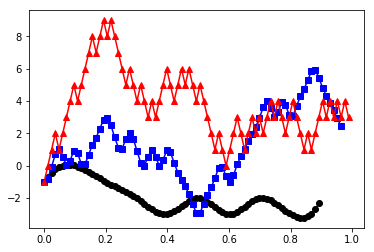

In [47]:
## upsample to fastest frequency

# in Hz
newSrate = np.max(fs)
whichIsFastest = np.argmax(fs)


# need to round in case it's not exact
newNpnts = np.round( len(signals[whichIsFastest]) * (newSrate/fs[whichIsFastest]) )

# new time vector after upsampling
newTime = np.arange(0,newNpnts) / newSrate


# ## continue on to interpolation
# # initialize (as matrix!)
newsignals = np.zeros( (len(fs),len(newTime)) )

for si in range(0,len(fs)):
    
    # interpolate using griddata
    newsignals[si,:] = griddata(timez[si], signals[si], newTime, method='cubic')
    


### plot for comparison
for si in range(0,3):
    plt.plot(newTime,newsignals[si,:],color[si]+shape[si]+'-')

plt.show()


---
# VIDEO: Interpolating
---


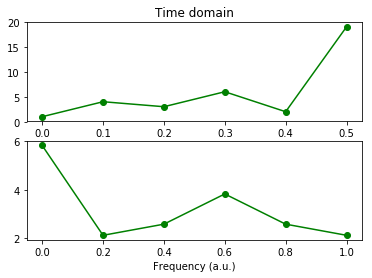

In [75]:
## low-sampling-rate data to upsample

# in Hz
srate = 10

# just some numbers...
data  = np.array( [1, 4, 3, 6, 2, 19] )

# other parameters
npnts = len(data)
time  = np.arange(0,npnts)/srate

# plot the original data
plt.subplot(211)
plt.plot(time,data,'go-')
plt.title('Time domain')

# amplitude spectrum
plt.subplot(212)
plt.plot(np.linspace(0,1,npnts),np.abs(scipy.fftpack.fft(data/np.array(npnts))),'go-')
plt.xlabel('Frequency (a.u.)')

plt.show()

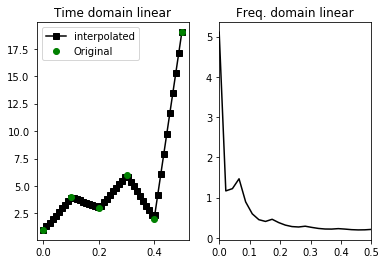

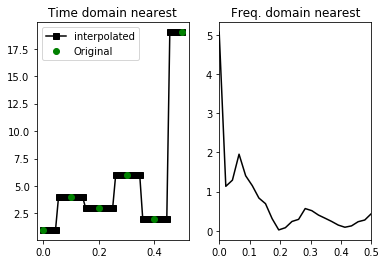

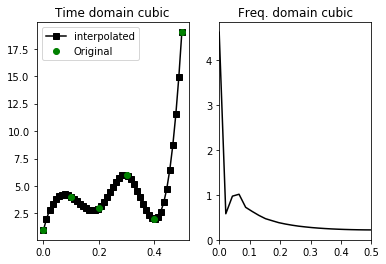

In [83]:
## interpolation

# new time vector for interpolation
N = 47
newTime = np.linspace(time[0],time[-1],N)

# different interpolation options
interpOptions = ['linear','nearest','cubic']


for methodi in range(0,len(interpOptions)):
    
    # interpolate using griddata
    newdata = griddata(time, data, newTime, method=interpOptions[methodi])
    
    # plotting
    plt.subplot(121)
    plt.plot(newTime,newdata,'ks-',label='interpolated')
    plt.plot(time,data,'go',label='Original')
    plt.title('Time domain '+interpOptions[methodi])
    plt.legend()
    
    plt.subplot(122)
    plt.plot(np.linspace(0,1,N),np.abs(scipy.fftpack.fft(newdata/N)),'k')
    plt.xlim([0,.5])
    plt.title('Freq. domain '+interpOptions[methodi])
    plt.show()
    


---
# VIDEO: Resample irregularly sampled data
---


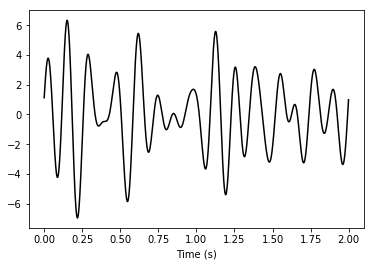

In [129]:
# simulation parameters
srate    = 1324    # Hz
peakfreq =    7    # Hz
fwhm     =    5    # Hz
npnts    = srate*2 # time points
timevec  = np.arange(0,npnts)/srate # seconds

# frequencies
hz = np.linspace(0,srate,npnts)
s  = fwhm*(2*np.pi-1)/(4*np.pi) # normalized width
x  = hz-peakfreq                # shifted frequencies
fg = np.exp(-.5*(x/s)**2)       # gaussian


# Fourier coefficients of random spectrum
fc = np.random.rand(npnts) * np.exp(1j*2*np.pi*np.random.rand(npnts))

# taper with Gaussian
fc = fc * fg

# go back to time domain to get signal
signal1 = 2*np.real( scipy.fftpack.ifft(fc) )*npnts


### plot 
plt.plot(timevec,signal1,'k')
plt.xlabel('Time (s)')
plt.show()

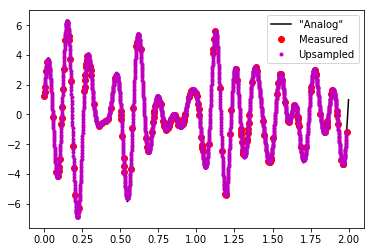

In [136]:
## now randomly sample from this "continuous" time series

# initialize to empty
sampSig = []


# random sampling intervals
sampintervals = np.append(1,np.cumsum(np.ceil( np.exp(4*np.random.rand(npnts)))))
sampintervals = sampintervals[sampintervals<np.array(npnts)]  # remove points beyond the data

# loop through sampling points and "measure" data
for i in range(0,len(sampintervals)):
    
    # "real world" measurement
    nextdat = signal1[ int(sampintervals[i]) ] , timevec[ int(sampintervals[i]) ]
    
    # put in data matrix
    sampSig.append(nextdat)

# needs to be numpy array
sampSig = np.array(sampSig)

## upsample to original sampling rate
# interpolate using griddata
newsignal = griddata(sampSig[:,1], sampSig[:,0], timevec, method='cubic')


### and plot everything
plt.plot(timevec,signal1,'k',label='"Analog"')
plt.plot(sampSig[:,1],sampSig[:,0],'ro',label='Measured')
plt.plot(timevec,newsignal,'m.',label='Upsampled')
plt.legend()

## optional zoom
#plt.xlim([1,1.1])

plt.show()


---
# VIDEO: Extrapolating
---


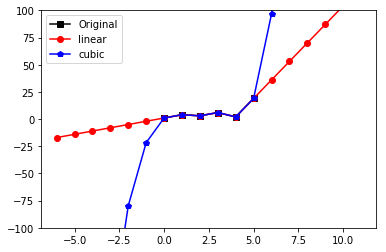

In [164]:
# get the landscape
signal1 = np.array( [1, 4, 3, 6, 2, 19] )
timevec = np.arange(0,len(signal1))


## two methods of extrapolation

times2extrap = np.arange(-len(signal1),2*len(signal1))


# get extrapolation classes
Flin = scipy.interpolate.interp1d(timevec,signal1,kind='linear',fill_value='extrapolate')
Fcub = scipy.interpolate.interp1d(timevec,signal1,kind='cubic',fill_value='extrapolate')

# now extra/interpolate
extrapLin = Flin(times2extrap)
extrapCub = Fcub(times2extrap)

# # plot them
plt.plot(timevec,signal1,'ks-',label='Original')
plt.plot(times2extrap,extrapLin,'ro-',label='linear')
plt.plot(times2extrap,extrapCub,'bp-',label='cubic')
plt.legend()

## optional zoom
plt.ylim([-100,100])

plt.show()


---
# VIDEO: Spectral interpolation
---


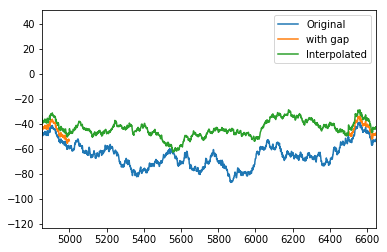

In [78]:
# number of points in signal
n = 10000

# create signal
origsig = np.cumsum( np.random.randn(n) )
signal1 = copy.deepcopy(origsig)


# remove a specified window
boundaryPnts = [ 5000, 6500 ]
signal1[range(boundaryPnts[0],boundaryPnts[1])] = np.nan


# FFTs of pre- and post-window data
fftPre = scipy.fftpack.fft(signal1[ range(boundaryPnts[0]-int(np.diff(boundaryPnts)),boundaryPnts[0])] )
fftPst = scipy.fftpack.fft(signal1[ range(boundaryPnts[1]+1,boundaryPnts[1]+int(np.diff(boundaryPnts)+1))] )

# interpolated signal is a combination of mixed FFTs and straight line
mixeddata = scipy.signal.detrend( np.real(scipy.fftpack.ifft( ( fftPre+fftPst )/2 )))
linedata  = np.linspace(0,1,int(np.diff(boundaryPnts))) * (signal1[boundaryPnts[1]+1]-signal1[boundaryPnts[0]-1]) + signal1[boundaryPnts[0]-1]

# sum together for final result
linterp = mixeddata + linedata

# put the interpolated piece into the signal
filtsig = copy.deepcopy( signal1 )
filtsig[ range(boundaryPnts[0],boundaryPnts[1]) ] = linterp

plt.plot(np.arange(0,n),origsig,label='Original')
plt.plot(np.arange(0,n),signal1+5,label='with gap')
plt.plot(np.arange(0,n),filtsig+10,label='Interpolated')
plt.legend()

## optional zoom
#plt.xlim([boundaryPnts[0]-150, boundaryPnts[1]+150])

plt.show()


---
# VIDEO: Dynamic time warping
---


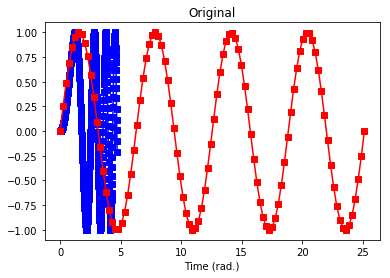

In [3]:
## create signals

# different time vectors
tx = np.linspace(0,1.5*np.pi,400)
ty = np.linspace(0,8*np.pi,100)

# different signals
x = np.sin(tx**2) # chirp
y = np.sin(ty);# sine wave


# show them
plt.plot(tx,x,'bs-')
plt.plot(ty,y,'rs-')
plt.xlabel('Time (rad.)')
plt.title('Original')
plt.show()

/home/mxc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


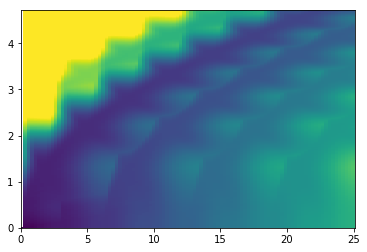

In [22]:
## distance matrix

# initialize distance matrix (dm) and set first element to zero
dm = np.zeros((len(x),len(y)))/0
dm[0,0] = 0

# distance matrix
for xi in range(1,len(x)):
    for yi in range(1,len(y)):
        cost = np.abs(x[xi]-y[yi])
        dm[xi,yi] = cost + np.nanmin([ dm[xi-1,yi], dm[xi,yi-1], dm[xi-1,yi-1] ])
        

plt.pcolormesh(ty,tx,dm,vmin=0,vmax=100)
plt.show()

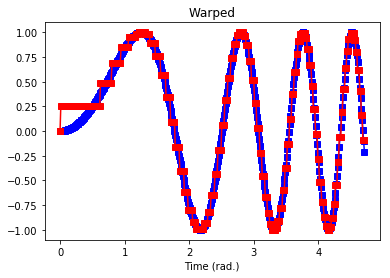

In [29]:
# find minimum for each y
minpath = np.zeros((2,len(x)),'int')

for xi in range(0,len(x)):
    minpath[0,xi] = np.nanmin(dm[xi,:])
    minpath[1,xi] = np.nanargmin(dm[xi,:])


plt.plot(tx,x,'bs-')
plt.plot(tx,y[minpath[1,:]],'rs-')
plt.xlabel('Time (rad.)')
plt.title('Warped')
plt.show()